In [1]:
from collections import defaultdict, Counter
import gc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_hdf('../../../input/train_online_retail.h5')
test = pd.read_hdf('../../../input/test_online_retail.h5')
df_all = pd.concat([train, test], sort=False)
del train, test
gc.collect()

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 12 to 541893
Data columns (total 11 columns):
invoice         1067371 non-null int32
stock_code      1067371 non-null int16
description     1062989 non-null object
quantity        1067371 non-null int32
invoice_date    1067371 non-null datetime64[ns]
price_unit      1067371 non-null float16
price_total     1067371 non-null float32
customer_id     1067371 non-null int16
country         1067371 non-null object
is_canceled     520142 non-null object
is_test         1067371 non-null bool
dtypes: bool(1), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(3)
memory usage: 60.1+ MB


In [3]:
def group_to_dict(group_key, agg_func):
    train = df_all[ ~df_all['is_canceled'].isnull()]
    dict_ = train.groupby(group_key)['is_canceled'].agg(agg_func).to_dict()
    if -1 in dict_: del dict_[-1]
        
    mean = np.mean( list(dict_.values()) )
    return defaultdict(lambda: mean, dict_)

In [4]:
# customer feats
df_all['cnt_customer_orders'] = df_all['customer_id'].map(group_to_dict('customer_id', agg_func=np.size))
df_all['cnt_customer_cancel'] = df_all['customer_id'].map(group_to_dict('customer_id', agg_func=np.sum))
df_all['prc_customer_cancel'] = df_all[['cnt_customer_orders', 'cnt_customer_cancel']].apply(lambda x: x['cnt_customer_cancel'] / x['cnt_customer_orders'] if x['cnt_customer_orders'] != 0 else 0, axis=1)

# produkt feats
df_all['cnt_product_orders'] = df_all['stock_code'].map(group_to_dict('customer_id', agg_func=np.size))
df_all['cnt_product_cancel'] = df_all['stock_code'].map(group_to_dict('customer_id', agg_func=np.sum))
df_all['prc_product_cancel'] = df_all[['cnt_product_orders', 'cnt_product_cancel']].apply(lambda x: x['cnt_product_cancel'] / x['cnt_product_orders'] if x['cnt_product_orders'] != 0 else 0, axis=1)

# date feats
df_all['invoice_year'] = df_all['invoice_date'].dt.year
df_all['invoice_month'] = df_all['invoice_date'].dt.month
df_all['invoice_day_of_m'] = df_all['invoice_date'].dt.day
df_all['invoice_day_of_y'] = df_all['invoice_date'].dt.dayofyear
df_all['invoice_hour'] = df_all['invoice_date'].dt.hour

# category feats
df_all['country__cat'] = pd.factorize(df_all['country'])[0]

In [209]:
#new feats
df_all.iloc[1, 4].dayofyear

335

In [215]:
df_all.sample(10)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,...,prc_customer_cancel,cnt_product_orders,cnt_product_cancel,prc_product_cancel,invoice_year,invoice_month,invoice_day_of_m,invoice_day_of_y,invoice_hour,country__cat
500138,27547,4479,BREAD BIN DINER STYLE RED,1,2010-11-29 16:45:00,34.000000,34.000000,-1,United Kingdom,NaN,...,0.023661,83.6942,1.98032,0.023661,2010,11,29,333,16,0
209981,38572,596,SET/20 RED RETROSPOT PAPER NAPKINS,1,2011-06-01 17:28:00,1.629883,1.630000,-1,United Kingdom,NaN,...,0.023661,10.0000,0,0.000000,2011,6,1,152,17,0
212979,38719,1328,IVORY DINER WALL CLOCK,1,2011-06-05 10:47:00,8.500000,8.500000,1483,United Kingdom,NaN,...,0.008230,286.0000,1,0.003497,2011,6,5,156,10,0
259249,41127,694,BASKET OF TOADSTOOLS,2,2011-07-11 16:21:00,1.250000,2.500000,-1,United Kingdom,False,...,0.023661,40.0000,0,0.000000,2011,7,11,192,16,0
525292,53039,193,WOODEN FRAME ANTIQUE WHITE,6,2011-12-05 12:03:00,2.949219,17.700001,4868,United Kingdom,False,...,0.000000,34.0000,1,0.029412,2011,12,5,339,12,0
37168,1756,558,VINTAGE BILLBOARD DRINK ME MUG,2,2009-12-16 17:58:00,2.570312,5.140000,-1,United Kingdom,False,...,0.023661,104.0000,0,0.000000,2009,12,16,350,17,0
259245,14942,3388,RED SPOTTY BEAKER,6,2010-07-02 11:44:00,1.950195,11.700000,3070,Germany,False,...,0.023810,265.0000,0,0.000000,2010,7,2,183,11,8
201969,38071,4083,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-05-24 08:49:00,9.953125,19.900000,4032,United Kingdom,False,...,0.050000,16.0000,0,0.000000,2011,5,24,144,8,0
391518,47439,4475,BREAD BIN DINER STYLE IVORY,1,2011-10-11 14:52:00,16.953125,16.950001,5594,France,False,...,0.040441,11.0000,0,0.000000,2011,10,11,284,14,1
502691,27709,4376,SET OF 20 VINTAGE CHRISTMAS NAPKINS,12,2010-11-30 16:26:00,0.850098,10.200000,213,United Kingdom,NaN,...,0.092593,83.6942,1.98032,0.023661,2010,11,30,334,16,0


In [171]:
num_order_canceled = df_all['stock_code'].map(group_to_dict('stock_code', agg_func=np.sum))
order_to_descr_dict = df_all.groupby('stock_code')['description']

In [205]:
n = df_all['stock_code'].value_counts()
stoc_kodes = list(n.index)
stock_desc_dic
for i in range(df_all.shape[0]):
    

In [154]:
all_describtions = list(df_all['description'])

In [158]:
all_describtions

['DOOR MAT BLACK FLOCK',
 'LOVE BUILDING BLOCK WORD',
 'HOME BUILDING BLOCK WORD',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'PEACE WOODEN BLOCK LETTERS',
 'CHRISTMAS CRAFT WHITE FAIRY',
 'HEART IVORY TRELLIS LARGE',
 'HEART FILIGREE DOVE LARGE',
 'FULL ENGLISH BREAKFAST PLATE',
 'PIZZA PLATE IN BOX',
 'BLACK DINER WALL CLOCK',
 'SET OF 3 BLACK FLYING DUCKS',
 'AREA PATROLLED METAL SIGN',
 'PLEASE ONE PERSON  METAL SIGN',
 'BATH BUILDING BLOCK WORD',
 'CLASSIC WHITE FRAME',
 'SMALL MARSHMALLOWS PINK BOWL',
 'BISCUITS SMALL BOWL LIGHT BLUE',
 'SCOTTIE DOG HOT WATER BOTTLE',
 'CHRISTMAS CRAFT HEART DECORATIONS',
 'CHRISTMAS CRAFT HEART STOCKING',
 'PARTY CONE CHRISTMAS DECORATION',
 'PEACE SMALL WOOD LETTERS',
 'JOY LARGE WOOD LETTERS',
 'CINAMMON & ORANGE WREATH',
 'EUCALYPTUS & PINECONE  WREATH',
 'WOODEN BOX ADVENT CALENDAR',
 'FLORAL BLUE MONSTER',
 'RETRO COFFEE MUGS ASSORTED',
 'INFLATABLE POLITICAL GLOBE',
 'STRIPES DESIGN MONKEY DOLL',
 'BLUE PADDED SOFT MOBILE',
 'PACK OF 6 SKULL PAPER

In [160]:
describtions_count = Counter(all_describtions)

In [164]:
describtions_count

Counter({'DOOR MAT BLACK FLOCK': 196,
         'LOVE BUILDING BLOCK WORD': 1798,
         'HOME BUILDING BLOCK WORD': 2192,
         'ASSORTED COLOUR BIRD ORNAMENT': 2958,
         'PEACE WOODEN BLOCK LETTERS': 376,
         'CHRISTMAS CRAFT WHITE FAIRY': 554,
         'HEART IVORY TRELLIS LARGE': 893,
         'HEART FILIGREE DOVE LARGE': 770,
         'FULL ENGLISH BREAKFAST PLATE': 695,
         'PIZZA PLATE IN BOX': 407,
         'BLACK DINER WALL CLOCK': 168,
         'SET OF 3 BLACK FLYING DUCKS': 308,
         'AREA PATROLLED METAL SIGN': 838,
         'PLEASE ONE PERSON  METAL SIGN': 181,
         'BATH BUILDING BLOCK WORD': 618,
         'CLASSIC WHITE FRAME': 239,
         'SMALL MARSHMALLOWS PINK BOWL': 636,
         'BISCUITS SMALL BOWL LIGHT BLUE': 263,
         'SCOTTIE DOG HOT WATER BOTTLE': 1846,
         'CHRISTMAS CRAFT HEART DECORATIONS': 75,
         'CHRISTMAS CRAFT HEART STOCKING': 208,
         'PARTY CONE CHRISTMAS DECORATION': 472,
         'PEACE SMALL WOOD LE

In [157]:
for i, desc in enumerate(all_describtions):
    all_describtions[i] = str(desc).strip()

In [148]:
all_describtions

{'DOOR MAT BLACK FLOCK', 'LOVE BUILDING BLOCK WORD'}

In [206]:
df_all[ df_all['stock_code'] == 188 ]

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
764,50,188,RED CHARLIE+LOLA PERSONAL DOORSIGN,1,2009-12-01 12:13:00,2.949219,2.950000,40,United Kingdom,False,False
4182,225,188,RED CHARLIE+LOLA PERSONAL DOORSIGN,96,2009-12-02 12:28:00,0.379883,36.480000,164,United Kingdom,False,False
23206,1123,188,RED CHARLIE+LOLA PERSONAL DOORSIGN,1,2009-12-10 12:21:00,2.949219,2.950000,704,United Kingdom,False,False
26542,1344,188,RED CHARLIE+LOLA PERSONAL DOORSIGN,1,2009-12-13 11:23:00,2.949219,2.950000,433,United Kingdom,False,False
34517,1676,188,RED CHARLIE+LOLA PERSONAL DOORSIGN,6,2009-12-16 11:46:00,2.949219,17.700001,933,United Kingdom,False,False
...,...,...,...,...,...,...,...,...,...,...,...
513509,52482,188,RED CHARLIE+LOLA PERSONAL DOORSIGN,1,2011-11-30 11:08:00,0.389893,0.390000,3949,United Kingdom,NaN,True
517276,52703,188,RED CHARLIE+LOLA PERSONAL DOORSIGN,1,2011-12-01 12:53:00,0.389893,0.390000,385,United Kingdom,NaN,True
517410,52709,188,RED CHARLIE+LOLA PERSONAL DOORSIGN,8,2011-12-01 13:08:00,0.389893,3.120000,5135,United Kingdom,NaN,True
530627,53212,188,RED CHARLIE+LOLA PERSONAL DOORSIGN,2,2011-12-06 12:12:00,0.389893,0.780000,4718,United Kingdom,NaN,True


In [88]:
df_all.sample(5)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,...,cnt_customer_cancel,prc_customer_cancel,cnt_product_orders,cnt_product_cancel,prc_product_cancel,invoice_year,invoice_month,day,invoice_hour,country__cat
387742,47274,1550,BLUE HAPPY BIRTHDAY BUNTING,2,2011-10-10 12:35:00,5.449219,10.900000,252,United Kingdom,NaN,...,83,0.024527,13.0000,0,0.000000,2011,10,10,12,0
179332,10042,3851,WHITE WOOD GARDEN PLANT LADDER,2,2010-04-29 13:20:00,9.953125,19.900000,351,Italy,NaN,...,5,0.063291,12.0000,0,0.000000,2010,4,29,13,11
188622,37280,3434,JUMBO SHOPPER VINTAGE RED PAISLEY,10,2011-05-13 10:09:00,2.080078,20.799999,962,United Kingdom,NaN,...,9,0.015762,83.6942,1.98032,0.023661,2011,5,13,10,0
517740,52735,4302,CARDHOLDER HOLLY WREATH METAL,8,2011-12-01 14:34:00,3.750000,30.000000,638,United Kingdom,False,...,3,0.024000,34.0000,0,0.000000,2011,12,1,14,0
450194,49996,4616,JAM MAKING SET WITH JARS,3,2011-11-08 17:53:00,4.250000,12.750000,5733,United Kingdom,True,...,2,0.060606,18.0000,0,0.000000,2011,11,8,17,0


# Train

In [5]:
def group_orders(df):
    orders = df.groupby('invoice')['is_canceled', 'price_total'].sum()
    orders['is_canceled'] = orders['is_canceled'].map(lambda x: True if x>0 else False)
    orders['price_canceled'] = orders['is_canceled'] * orders['price_total']
    return orders

In [6]:
def get_feats_X_y(df):
    
    # select feats
    black_list = ['is_canceled', 'is_test']
    feats = df.select_dtypes([np.bool, np.number]).columns
    feats = [x for x in feats if x not in black_list]
                  
    X = df[feats]
    y = df['is_canceled']
    
    return X, y, feats

In [7]:
# prepare to train
train = df_all[ ~df_all['is_test'] ].copy()
test = df_all[ df_all['is_test'] ].copy()

#release memory
del df_all
gc.collect()

123

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520142 entries, 12 to 541909
Data columns (total 23 columns):
invoice                520142 non-null int32
stock_code             520142 non-null int16
description            517903 non-null object
quantity               520142 non-null int32
invoice_date           520142 non-null datetime64[ns]
price_unit             520142 non-null float16
price_total            520142 non-null float32
customer_id            520142 non-null int16
country                520142 non-null object
is_canceled            520142 non-null object
is_test                520142 non-null bool
cnt_customer_orders    520142 non-null float64
cnt_customer_cancel    520142 non-null object
prc_customer_cancel    520142 non-null float64
cnt_product_orders     520142 non-null float64
cnt_product_cancel     520142 non-null object
prc_product_cancel     520142 non-null float64
invoice_year           520142 non-null int64
invoice_month          520142 non-null int64
invoice_

In [9]:
train['cnt_product_cancel'] = train['cnt_product_cancel'].astype(float)
train['cnt_customer_cancel'] = train['cnt_customer_cancel'].astype(float)

test['cnt_product_cancel'] = test['cnt_product_cancel'].astype(float)
test['cnt_customer_cancel'] = test['cnt_customer_cancel'].astype(float)

train['is_canceled'] = train['is_canceled'].astype(bool)

In [17]:
orders = group_orders(train)

X = orders[ [ 'is_canceled' ] ]
y = orders[ 'price_canceled' ]

model = DummyRegressor(strategy='mean')
model.fit(X, y)
y_pred = model.predict(X)

score = mean_squared_error(y, y_pred)
score

1492585.5

In [ ]:
train['is_canceled'].value_counts(normalize=True)

In [ ]:
orders['is_canceled'].value_counts(normalize=True)

In [13]:
def test_model(model, scoring='recall', check_distribution=False):
    cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print('scores: {}'.format(scores))
    print('mean: {}, std: {} \n'.format(np.mean(scores), np.std(scores)))
    
    if check_distribution:
        y_pred = pd.Series(cross_val_predict(model, X, y, cv=cv))
        print('y_pred value_counts: \n{}'.format(y_pred.value_counts(normalize=True)))

In [14]:
def plot_model_char(model, check_confusion=True, check_feature_importance=True, check_learning_curve=True):
    
    if check_confusion:
        cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
        y_pred = cross_val_predict(model, X, y, cv=cv)
        skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True, figsize=(10 ,10))
    
    if check_feature_importance or check_learning_curve:
        model.fit(X, y)
    
    if check_feature_importance:
        skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
    
    if check_learning_curve:
        skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='recall');

In [10]:
X, y, feats = get_feats_X_y(train)
feats

['invoice',
 'stock_code',
 'quantity',
 'price_unit',
 'price_total',
 'customer_id',
 'cnt_customer_orders',
 'cnt_customer_cancel',
 'prc_customer_cancel',
 'cnt_product_orders',
 'cnt_product_cancel',
 'prc_product_cancel',
 'invoice_year',
 'invoice_month',
 'invoice_day_of_m',
 'invoice_day_of_y',
 'invoice_hour',
 'country__cat']

In [99]:
model = DecisionTreeClassifier(max_depth=10, random_state=0)
test_model(model)

scores: [0.36352693 0.33383504 0.33955449]
mean: 0.3456388192922442, std: 0.012862516297041564 



In [ ]:
plot_model_char(model)

In [27]:
xgb_params = {
    'max_depth' : 10,
    'n_estimators' : 100,
    'learning_rate': 0.3,
    'seed': 0
}

In [28]:
model = XGBClassifier(**xgb_params)
test_model(model)

scores: [0.56695757 0.57074052 0.5590006 ]
mean: 0.5655662294231926, std: 0.004892734305801641 



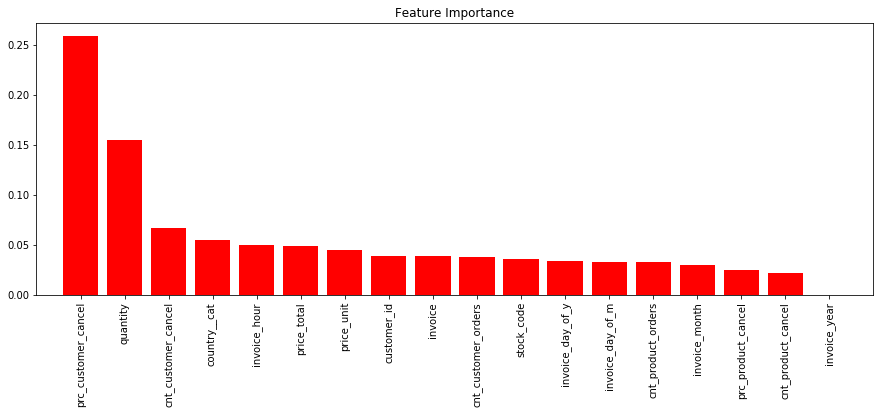

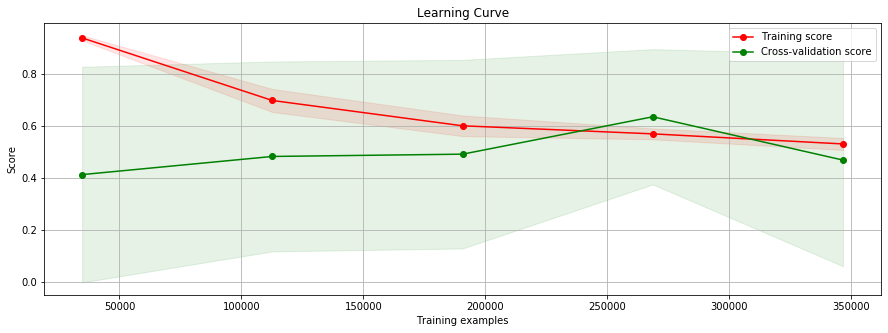

In [25]:
plot_model_char(model, False, True, True)

In [ ]:
# m = XGBClassifier(**xgb_params)
# m.fit(X,y)

# imp = PermutationImportance(m, random_state=0).fit(X,y)
# eli5.show_weights(imp, feature_names=feats)

In [ ]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror',
        'random_state':0
    }
    
    model = XGBClassifier(**xgb_params)
    
    cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring='recall')
    
    score = 1 - np.men(scores)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

In [26]:
#train and predict

model = XGBClassifier(**xgb_params)
model.fit(train[feats], train['is_canceled'])
test['is_canceled'] = model.predict(test[feats])

#prepare submit
test['total_return'] = test['price_total'] * test['is_canceled']
result = test.groupby('invoice')['total_return'].agg(np.sum).to_frame().reset_index()

result[ ['invoice', 'total_return'] ].to_csv('../../../output/xgb_and_cnt_features.csv', index=False)